## Metabolic Engineering Notebook

Overall, the following papers are some of the pivotal references and will used to choose proper heterologous pathways to add to models as well as the suitability of each strain to serve as a starting point or chassis for further metabolic engineering efforts:
1. [Won et al., 2021](https://doi.org/10.1007/s00284-021-02588-5) (In Vitro Antidiabetic, Antioxidant Activity, and Probiotic Activities of *Lactiplantibacillus plantarum* and *Lacticaseibacillus paracasei* Strains): Explains some of the mechanisms by which the strains are acid-resistant and alleviate symptoms such as the prevalence of ROS and hyperglycemia under the section **Discussion**.
2. [Klinger et al., 2015](https://doi.org/10.1128/AEM.03157-14) (Large-Scale 13C Flux Profiling Reveals Conservation of the Entner-Doudoroff Pathway as a Glycolytic Strategy among Marine Bacteria That Use Glucose): Its abstract points out an interesting observation regarding the prevalence and potential evolutionary advantage of ED compared to EMP in marine bacteria:

    "Marine bacteria form one of the largest living surfaces on Earth, and their metabolic activity is of fundamental importance for global nutrient cycling. Here, we explored the largely unknown intracellular pathways in 25 microbes representing different classes of marine bacteria that use glucose: *Alphaproteobacteria*, *Gammaproteobacteria*, and *Flavobacteriia* of the *Bacteriodetes* phylum. We used 13C isotope experiments to infer metabolic fluxes through their carbon core pathways. Notably, 90% of all strains studied use the **Entner-Doudoroff** (ED) pathway for glucose catabolism, whereas only 10% rely on the Embden-Meyerhof-Parnas (EMP) pathway. This result differed dramatically from the terrestrial model strains studied, which preferentially used the EMP pathway yielding high levels of ATP. Strains using the ED pathway exhibited a more robust resistance against the oxidative stress typically found in this environment."

3. [El Husseini et al., 2023](https://doi.org/10.1128/jb.00361-23) (Characterization of the Entner-Doudoroff pathway in Pseudomonas aeruginosa catheter-associated urinary tract infections):

    "Pseudomonas aeruginosa is an opportunistic nosocomial pathogen responsible for a subset of catheter-associated urinary tract infections (CAUTI). In a murine model of P. aeruginosa CAUTI, we previously demonstrated that urea within urine suppresses quorum sensing and induces the Entner-Doudoroff (E-D) pathway. The E-D pathway consists of the genes zwf, pgl, edd, and eda. Zwf and Pgl convert glucose-6-phosphate into 6-phosphogluconate. Edd hydrolyzes 6-phosphogluconate to 2-keto-3-deoxy-6-phosphogluconate (KDPG). Finally, Eda cleaves KDPG to glyceraldehyde-3-phosphate and pyruvate, which enters the citric acid cycle."

    <img src="ed_pathway.png" alt="EDpathway" width="1000"/>

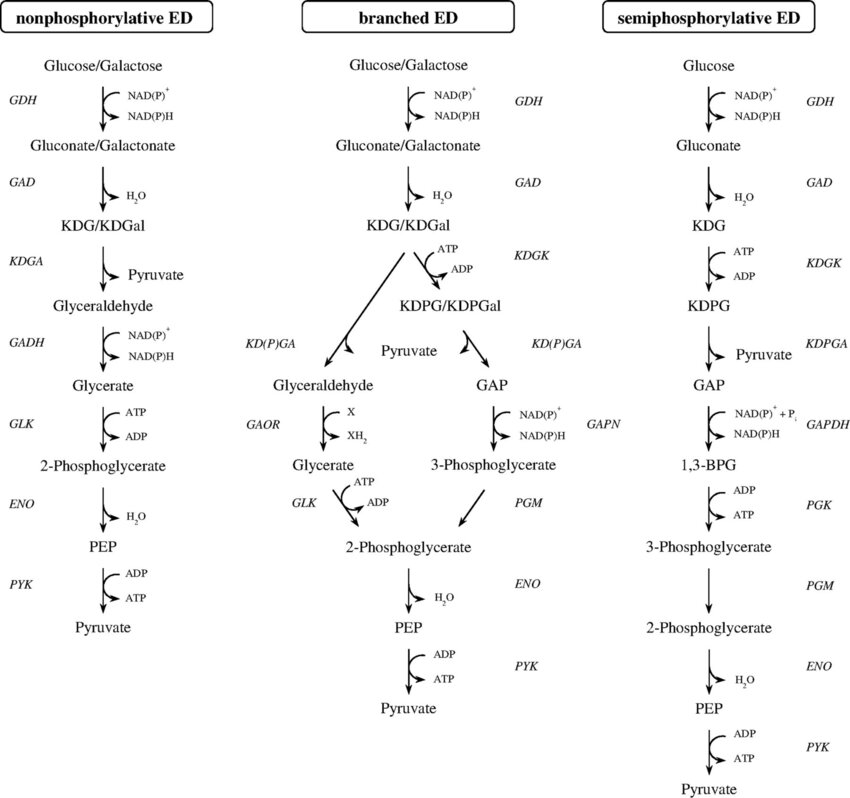

*Figure*. These three alternatives have been proposed as different versions of the standard ED pathway that exist in Archaea. Of particular interest is the one on the left, the nonphosphorylative ED or **npED** pathway. Even though it is the only version that has zero net yield of ATP, it is nonetheless the shortest and thus the most suitable one for producing more lactate (by providing more of its precursor, lactate) and consuming more glucose in a shorter timespan.

### Goals

This step of the project's pipeline aims to improve the yields of lactate in *L. plantarum* WCFS1 and *L. brevis* ATCC 367, which have been chosen for their diverse metabolism and their good performance in the pairwise cocultures of the previous step. Unlike traditional metabolic engineering, which involved directed evolutionary processes and screening of random mutations to reach higher yields for a product of interest, synthetic biology and its modern approach to metabolic engineering involves using computational tools to rationally design strains of choice. This approach, wherein strategic gene knockouts and 'knock-ins' (i.e. introduction of new reactions or entire pathways) can improve the yield and tie growth to the production of desirable product(s), are referred to as **growth-coupled selection**, which results in **growth-coupled production** (GCP) in engineered strains ([Osri et al., 2021]()). On par with the principles of synthetic biology, modularity in simulations and *in silico* assessments could be useful. The extent to which GCP forces the cell to perform a metabolic function of interest while growing is defined as 4 different stages:
* Weak GCP (wGCP)
* Directed GCP (dGCP)
* Strong GCP (sGCP)
* Substrate-uptake Growth Dependence (SU)

### Utility Functions

#### Search Functions

In [13]:
import cobra
import numpy as np
import pandas as pd

# Defining simple utility functions for searching the name of metabolites and reactions
def find_metabolites(model : cobra.Model, metabolite : str, id_search = False):
    for met in model.metabolites:
        if (id_search):
            if (metabolite in met.id):
                print('Name %s' % met.name)
                print('ID: %s' % met.id)
        else:
            if (metabolite in met.name):
                print('Name %s' % met.name)
                print('ID: %s' % met.id)

def find_reactions(model : cobra.Model, reaction : str, id_search = False):
    for rxn in model.reactions:
        if (id_search):
            if (reaction in rxn.id):
                print('Name %s' % rxn.name)
                print('ID: %s' % rxn.id)
        else:
            if (reaction in rxn.name):
                print('Name %s' % rxn.name)
                print('ID: %s' % rxn.id)

def find_rxn_met(model : cobra.Model, reaction : str | None = None, metabolite : str | None = None):
    if (reaction):
        for rxn in model.reactions:
            if reaction in rxn.name:
                print('Found!')
                print('Name:', rxn.name)
                print('ID:', rxn.id)
                print('Reaction formula:', rxn.reaction)
    if (metabolite):
        for met in model.metabolites:
            if metabolite in met.name:
                print('Found!')
                print('Name:', met.name)
                print('ID:', met.id)
                for rxn in met.reactions:
                    print('Related reaction:', rxn.id, rxn.name, rxn.reaction)

#### Print Reactions

In [14]:
def print_reactions(list_of_reactions : list[cobra.Reaction] | set[cobra.Reaction]):
    for rxn in list_of_reactions:
        print(rxn.id, " | ", rxn.name)

#### Convert ID Formats

In [70]:
def convert_ids(model : cobra.Model, agora_mode = False):
    for met in model.metabolites:
        if agora_mode:
            met.id = met.id.replace('_c', '[c]')
            met.id = met.id.replace('_p', '[p]')
            met.id = met.id.replace('_e', '[e]')
        else:
            met.id = met.id.replace('[c]', '_c')
            met.id = met.id.replace('[p]', '_p')
            met.id = met.id.replace('[e]', '_e')
    for rxn in model.reactions:
        if agora_mode:
            rxn.id = rxn.id.replace('_c', '(c)')
            rxn.id = rxn.id.replace('_p', '(p)')
            rxn.id = rxn.id.replace('_e', '(e)')
        else:
            rxn.id = rxn.id.replace('(c)', '_c')
            rxn.id = rxn.id.replace('(p)', '_p')
            rxn.id = rxn.id.replace('(e)', '_e')

#### Custom Strain Design Function

In [ ]:
def ko_ki_strain_design(model : cobra.Model, reactions_to_ko : list[cobra.Reaction] | None = None, genes_to_ki : list[cobra.Reaction] | None = None):
    pass

### Basic Assessment of the ED Pathway

In [1]:
import cobra
import cameo
import straindesign as sd

In [2]:
# Load models iteratively
models_dictionary = {}
strains = ["Lactobacillus_brevis_ATCC_367", "Lactobacillus_plantarum_JDM1",
           "Lactobacillus_plantarum_WCFS1", "Pseudomonas_aeruginosa_NCGM2_S1","Pseudomonas_aeruginosa_PAO1",
           "Staphylococcus_aureus_subsp_aureus_USA300_FPR3757", "Bacteroides_fragilis_NCTC_9343"]
strains_short = ["l_brevis_atcc367", "l_plantarum_jdm1", "l_plantarum_wcfs1", "p_aeruginosa_ncgm2_s1", "p_aeruginosa_pao1", "s_aureus_usa300", "b_fragilis_nctc_9343"]

# Define PATH constant prefix
PATH = f"../model_data/"
for index, strain in enumerate(strains):
    models_dictionary[strains_short[index]] = PATH + strains[index] + ".xml"

In [3]:
# Loading P. aeruginosa to assess the availability of the ED pathway genes and reactions
p_aeruginosa_pao1 = cameo.load_model(models_dictionary['p_aeruginosa_pao1'])

In [46]:
# Using the search utility functions to extract information regarding the pathway
find_metabolites(p_aeruginosa_pao1, 'glucose')
find_metabolites(p_aeruginosa_pao1, 'g6p', id_search=True)
find_metabolites(p_aeruginosa_pao1, 'lactone')
find_metabolites(p_aeruginosa_pao1, 'gluconate')
find_metabolites(p_aeruginosa_pao1, '2-dehydro-3-deoxy')
find_metabolites(p_aeruginosa_pao1, 'Pyruvate')

Name CDP-3,6-dideoxy-D-glucose
ID: cdp36ddoglu[c]
Name CDP-4-dehydro-3-6-dideoxy-D-glucose
ID: cdp4dh36ddglc[c]
Name CDP-4-dehydro-6-deoxy-D-glucose
ID: cdpddg[c]
Name CDPglucose
ID: cdpglc[c]
Name dTDP-4-dehydro-6-deoxy-alpha-D-glucose(2-)
ID: dtdp4d6dg[c]
Name dTDP-glucose(2-)
ID: dtdpglu[c]
Name dTDP-3-oxo-4,6-dideoxy-D-glucose
ID: dtdpodglu[c]
Name beta-D-glucose 6-phosphate
ID: g6p_B[c]
Name GDP-glucose
ID: gdpglc[c]
Name D-glucose
ID: glc_D[c]
Name D-glucose
ID: glc_D[e]
Name D-glucose
ID: glc_D[p]
Name beta D-glucose
ID: glc_bD[c]
Name UDPglucose
ID: udpg[c]
Name 2-Dehydro-3-deoxy-D-gluconate 6-phosphate
ID: 2ddg6p[c]
Name D-Glucose 6-phosphate
ID: g6p[c]
Name beta-D-glucose 6-phosphate
ID: g6p_B[c]
Name Muconolactone
ID: 25d5o2a[c]
Name 3-Methylmuconolactone
ID: 3mmlctn[c]
Name 4-Methylmuconolactone
ID: 4mmlctn[c]
Name 6-phospho-D-glucono-1,5-lactone
ID: 6pgl[c]
Name cis-2-Chlorodienelactone
ID: c2chdlac[c]
Name Deoxylimononic acid D-ring-lactone
ID: dolmntrl[c]
Name Gluconolac

The found metabolites of the ED pathway have the following IDs:
1. D-Glucose (glc_D[c])
2. D-Glucose 6-phosphate (g6p[c])
3. 6-phospho-D-glucono-1,5-lactone (6pgl[c])
4. 6-Phospho-D-gluconate (6pgc[c])
5. 3-Dehydro-2-deoxy-D-gluconate (3ddgc[c])
6. Pyruvate (pyr[c])

In [47]:
# Compiling a list of the aforementioned metabolites
ed_metabolites = []
ed_metabolites.append(p_aeruginosa_pao1.metabolites.get_by_id('glc_D[c]'))
ed_metabolites.append(p_aeruginosa_pao1.metabolites.get_by_id('g6p[c]'))
ed_metabolites.append(p_aeruginosa_pao1.metabolites.get_by_id('6pgl[c]'))
ed_metabolites.append(p_aeruginosa_pao1.metabolites.get_by_id('6pgc[c]'))
ed_metabolites.append(p_aeruginosa_pao1.metabolites.get_by_id('3ddgc[c]'))
ed_metabolites.append(p_aeruginosa_pao1.metabolites.get_by_id('pyr[c]'))

In [48]:
# Printing out the associated reactions for each of the metabolites to find the common ED pathway
set_of_reactions = ed_metabolites[0].reactions
for rxn in set_of_reactions:
    print(rxn.id, " | ", rxn.name)

XYLI2  |  xylose isomerase
BGLA  |  1,4-beta-D-Glucan glucohydrolase
TREH  |  Alpha, Alpha-Trehalase
MADGBG  |  beta-glucosidase (methyl-alpha-D-glucoside)
MBDGBG  |  beta-glucosidase
S1FBFRCTSLT  |  Sucrose:sucrose 1F-beta-D-fructosyltransferase
G1PPTi  |  D Glucose 1 phosphate D glucose 1 phosphate 6 phosphotransferase irreversible
GALM1r  |  aldose 1-epimerase (glucose), reversible


In [7]:
# Constructing the standard ED pathway from metabolites and reactions
standard_ed_pathway = [
    p_aeruginosa_pao1.reactions.G6PI,
    p_aeruginosa_pao1.reactions.PGL,
    p_aeruginosa_pao1.reactions.EDD,
    p_aeruginosa_pao1.reactions.DOGDH,
]

In [50]:
# Searching for alternative enzymes/reactions
find_reactions(p_aeruginosa_pao1, 'cose dehydrogenase')
p_aeruginosa_pao1.reactions.GLCDepp # Although this is glucose dehydrogenase, it is a periplasmic isoform of the cytosolic enzyme I am looking for
find_metabolites(p_aeruginosa_pao1, 'D-gluconate')
find_reactions(p_aeruginosa_pao1, '2-keto-3-')
KGDA = p_aeruginosa_pao1.metabolites.get_by_id('glcn[e]').reactions
for rxn in KGDA:
    print(rxn.id, " | ", rxn.name)
find_reactions(p_aeruginosa_pao1, 'lyceraldehyde')
p_aeruginosa_pao1.reactions.ALDD8x

Name Glucose dehydrogenase (ubiquinone-8 as acceptor), periplasmatic
ID: GLCDepp
Name 2-Dehydro-3-deoxy-D-gluconate 6-phosphate
ID: 2ddg6p[c]
Name 2-Dehydro-3-deoxy-D-gluconate
ID: 2ddglcn[c]
Name 2-Deoxy-D-gluconate
ID: 2dglcn[c]
Name 2-Dehydro-D-gluconate
ID: 2dhglcn[c]
Name 3-Dehydro-2-deoxy-D-gluconate
ID: 3ddgc[c]
Name 6-Phospho-D-gluconate
ID: 6pgc[c]
Name 2,5-Diketo-3-deoxy-D-gluconate
ID: dkdglcn[c]
Name D-gluconate
ID: glcn[c]
Name D-gluconate
ID: glcn[e]
Name D-gluconate
ID: glcn[p]
GLCNtex  |  D-gluconate diffusion extracellular to periplasm
EX_glcn(e)  |  D-Gluconate exchange
Name aldehyde dehydrogenase D glyceraldehyde NAD
ID: ALDD8x
Name D-Fructose 1-Phosphate D-Glyceraldehyde-3-Phosphate-Lyase
ID: FBA2
Name Sedoheptulose 1,7-bisphosphate D-glyceraldehyde-3-phosphate-lyase
ID: FBA3
Name Glyceraldehyde-3-Phosphate Dehydrogenase
ID: GAPD
Name D-Glyceraldehyde-3-phosphate:NADP+ oxidoreductase(phosphorylating)
ID: GAPD_NADP
Name D-Glyceraldehyde 3-phosphate phosphatase
ID: GL

Reaction identifier,ALDD8x
Name,aldehyde dehydrogenase D glyceraldehyde NAD
Memory address,0x26c560814f0
Stoichiometry,glyald[c] + h2o[c] + nad[c] --> glyc_R[c] + 2.0 h[c] + nadh[c] D-Glyceraldehyde + Water + Nicotinamide adenine dinucleotide --> D-glycerate + 2.0 proton + Nicotinamide adenine dinucleotide - reduced
GPR,WP_003114258.1 or WP_047695862.1 or WP_003114512.1 or WP_003113043.1 or DW52_RS0111225 or...
Lower bound,0.0
Upper bound,1000.0


By using the above cell to perform a step-by-step search for the enzymes in a npED pathway, I found out that `KDGA` and `GAD` do not exist in P. aeruginosa and I must retrieve their info from an outer source.

In [5]:
# Constructing the semiphosphorylative and nonphosphorylative versions of ED
np_ed_pathway = [
    p_aeruginosa_pao1.reactions.GLCDepp,
    cobra.Reaction('KGDA', "2-keto-3-deoxygluconate aldolase"),
    p_aeruginosa_pao1.reactions.ALDD8x,
]

In [52]:
print_reactions(np_ed_pathway)

GLCDepp  |  Glucose dehydrogenase (ubiquinone-8 as acceptor), periplasmatic
KGDA  |  2-keto-3-deoxygluconate aldolase
ALDD8x  |  aldehyde dehydrogenase D glyceraldehyde NAD


In [53]:
find_reactions(p_aeruginosa_pao1, 'gluconate dehydratase')

Name 6-phosphogluconate dehydratase
ID: EDD


### Heterologous Pathway Expression in *L. plantarum* WCFS1

In order to investigate the effects of expressing the 4 enzymes of the ED pathway in *L. plantarum* WCFS1, the reactions separated earlier were added to the *Lactobacillus* model.

In [8]:
l_plantarum_wcfs1 = cobra.io.read_sbml_model(models_dictionary['l_plantarum_wcfs1'])

In [11]:
# Production before gene addition
l_plantarum_wcfs1.summary()
#lp_wcfs1_pp = cobra.flux_analysis.production_envelope(l_plantarum_wcfs1, l_plantarum_wcfs1.reactions, carbon_sources=[l_plantarum_wcfs1.reactions.get_by_id('EX_glc_D(e)')])
#lp_wcfs1_pp

Metabolite,Reaction,Flux,C-Number,C-Flux
acnam[e],EX_acnam(e),38.67,11,3.02%
alathr[e],EX_alathr(e),16.01,7,0.80%
anzp[e],EX_anzp(e),227.3,15,24.24%
arg_L[e],EX_arg_L(e),16.57,6,0.71%
ca2[e],EX_ca2(e),1.476,0,0.00%
cit[e],EX_cit(e),53.68,6,2.29%
cl[e],EX_cl(e),1.476,0,0.00%
cobalt2[e],EX_cobalt2(e),1.476,0,0.00%
cu2[e],EX_cu2(e),1.476,0,0.00%
fe2[e],EX_fe2(e),2.953,0,0.00%


In [12]:
l_plantarum_wcfs1.add_reactions(standard_ed_pathway)
l_plantarum_wcfs1.summary()

Ignoring reaction 'G6PI' since it already exists.
Ignoring reaction 'PGL' since it already exists.


Metabolite,Reaction,Flux,C-Number,C-Flux
7a_czp[e],EX_7a_czp(e),227.3,15,24.24%
acnam[e],EX_acnam(e),38.67,11,3.02%
alathr[e],EX_alathr(e),16.01,7,0.80%
arg_L[e],EX_arg_L(e),16.57,6,0.71%
ca2[e],EX_ca2(e),1.476,0,0.00%
cit[e],EX_cit(e),53.68,6,2.29%
cl[e],EX_cl(e),1.476,0,0.00%
cobalt2[e],EX_cobalt2(e),1.476,0,0.00%
cu2[e],EX_cu2(e),1.476,0,0.00%
fe2[e],EX_fe2(e),2.953,0,0.00%


The growth and flux distribution does not change significantly after the addition of ED pathway

### Flux Space Analysis and Coupled Growth (Aim 1B)

Production envelopes project the flux space of feasible steady-state flux vectors onto two dimensions whereas each dimension is a flux rate. Yield spaces map feasible yield combinations onto two dimensions where each dimension is a flux ratio.

Production envelopes project the solution space of steady-state flux vectors onto the dimensions of growth rate and product synthesis rate.

In [5]:
import cameo
import straindesign as sd

#### DFU Medium and Constraints

Since the chosen strains from the cocultures (i.e. L. plantarum WCFS1 and JDM1) are to be grown on the DFU medium, the medium has to be considered in the engineering process.

In [3]:
# Loading the models
l_plantarum_jdm1 = cobra.io.read_sbml_model(models_dictionary['l_plantarum_jdm1'])
l_plantarum_wcfs1 = cobra.io.read_sbml_model(models_dictionary['l_plantarum_wcfs1'])
l_brevis = cobra.io.read_sbml_model(models_dictionary['l_brevis_atcc367'])

In [71]:
# Converting the format of models to make them compatible with StrainDesign
convert_ids(l_plantarum_jdm1)
convert_ids(l_brevis)

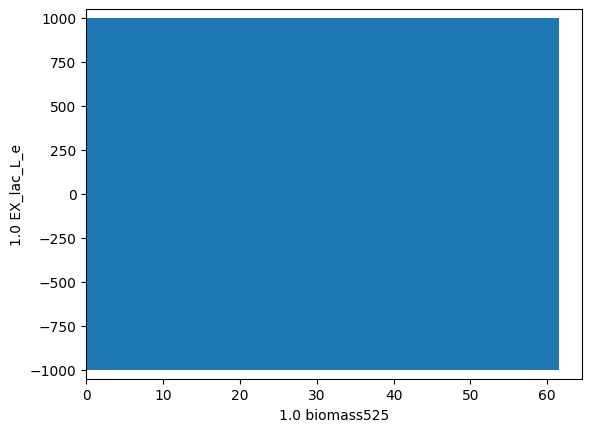

([[0.0, -1000.0],
  [1.5760739053846156, -1000.0],
  [3.152147810769231, -1000.0],
  [4.728221716153847, -1000.0],
  [6.304295621538462, -1000.0],
  [7.880369526923078, -1000.0],
  [9.456443432307694, -1000.0],
  [11.032517337692308, -1000.0],
  [12.608591243076924, -1000.0],
  [14.18466514846154, -1000.0],
  [15.760739053846155, -1000.0],
  [17.33681295923077, -1000.0],
  [18.912886864615388, -1000.0],
  [20.488960770000002, -1000.0],
  [22.065034675384616, -1000.0],
  [23.641108580769234, -1000.0],
  [25.21718248615385, -1000.0],
  [26.793256391538463, -1000.0],
  [28.36933029692308, -1000.0],
  [29.945404202307696, -1000.0],
  [31.52147810769231, -1000.0],
  [33.09755201307693, -1000.0],
  [34.67362591846154, -1000.0],
  [36.24969982384616, -1000.0],
  [37.825773729230775, -1000.0],
  [39.401847634615386, -1000.0],
  [40.977921540000004, -1000.0],
  [42.55399544538462, -1000.0],
  [44.13006935076923, -1000.0],
  [45.70614325615385, -1000.0],
  [47.28221716153847, -1000.0],
  [48.858

In [76]:
# Drawing a flux space to see how much the growth is coupled with lactic acid production (through the LDH reaction) and secretion
sd.plot_flux_space(l_brevis, ('biomass525', ['EX_lac_L_e']))

As it can be seen, *L. brevis* does not show any form of coupling between its growth and its production of lactate.

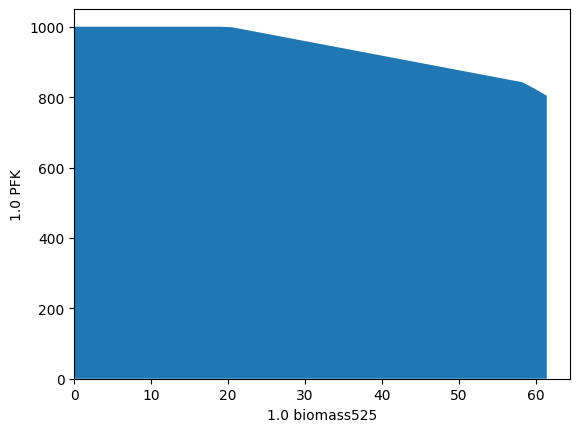

([[0.0, 0.0],
  [1.5760739053846156, 0.0],
  [3.152147810769231, 0.0],
  [4.728221716153847, 0.0],
  [6.304295621538462, 0.0],
  [7.880369526923078, 0.0],
  [9.456443432307694, 0.0],
  [11.032517337692308, 0.0],
  [12.608591243076924, 0.0],
  [14.18466514846154, 0.0],
  [15.760739053846155, 0.0],
  [17.33681295923077, 0.0],
  [18.912886864615388, 0.0],
  [20.488960770000002, 0.0],
  [22.065034675384616, 0.0],
  [23.641108580769234, 0.0],
  [25.21718248615385, 0.0],
  [26.793256391538463, 0.0],
  [28.36933029692308, 0.0],
  [29.945404202307696, 0.0],
  [31.52147810769231, 0.0],
  [33.09755201307693, 0.0],
  [34.67362591846154, 0.0],
  [36.24969982384616, 0.0],
  [37.825773729230775, 0.0],
  [39.401847634615386, 0.0],
  [40.977921540000004, 0.0],
  [42.55399544538462, 0.0],
  [44.13006935076923, 0.0],
  [45.70614325615385, 0.0],
  [47.28221716153847, 0.0],
  [48.85829106692308, 0.0],
  [50.4343649723077, 0.0],
  [52.010438877692316, 0.0],
  [53.58651278307693, 0.0],
  [55.162586688461545

In [45]:
import straindesign as sd
sd.plot_flux_space(l_brevis, ('biomass525', 'PFK'))

In [8]:
# Defining a function to load the DFU medium and adapt it to the microorganism
import pandas as pd

def load_medium(file_path = '../env/dfu_medium.csv'):
    dfu_df = pd.read_csv(file_path)
    dfu_dict = dfu_df.to_dict(orient='list')
    for e, f in zip(dfu_dict['exchange'], dfu_dict['flux']):
        e = e.replace('_m', '(e)')
        dfu_dict[e] = f
    dfu_dict.pop('exchange')
    dfu_dict.pop('flux')
    return dfu_dict

In [18]:
# Performing FVA analysis on L. plantarum WCFS1
fva_wcfs1 = cameo.flux_variability_analysis(l_plantarum_wcfs1)

C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cameo\flux_analysis\analysis.py:419: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.lower_bound[lb_

In [16]:
find_rxn_met(l_plantarum_wcfs1, None, 'lactate')

Found!
Name: (S)-2-Acetolactate
ID: alac_S[c]
Related reaction: ACLDC acetolactate decarboxylase alac_S[c] + h[c] --> actn_R[c] + co2[c]
Found!
Name: D-lactate
ID: lac_D[c]
Related reaction: D_LACD D-Lactate dehydrogenase irreversible 2.0 ficytC[c] + lac_D[c] --> 2.0 focytC[c] + 2.0 h[c] + pyr[c]
Related reaction: D_LACt2 D-Lactate Transport via Proton Symport h[e] + lac_D[e] <=> h[c] + lac_D[c]
Related reaction: LDH_D D-Lactate Dehydrogenase lac_D[c] + nad[c] <=> h[c] + nadh[c] + pyr[c]
Related reaction: LDH_D2 D-lactate dehydrogenase lac_D[c] + q8[c] --> pyr[c] + q8h2[c]
Found!
Name: D-lactate
ID: lac_D[e]
Related reaction: D_LACt2 D-Lactate Transport via Proton Symport h[e] + lac_D[e] <=> h[c] + lac_D[c]
Related reaction: EX_lac_D(e) D-lactate exchange lac_D[e] <=> 
Found!
Name: L-lactate
ID: lac_L[c]
Related reaction: L_LACt2r L-Lactate Reversible Transport via Proton Symport h[e] + lac_L[e] <=> h[c] + lac_L[c]
Related reaction: L_LACD3 L-Lactate dehydrogenase (menaquinone) lac_L[c

In [20]:
wcfs1_ppp = cameo.phenotypic_phase_plane(l_plantarum_wcfs1, ['PFK'], l_plantarum_wcfs1.metabolites.get_by_id('lac_L[c]'))

C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cameo\flux_analysis\analysis.py:419: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.lower_bound[lb_

In [20]:
# Drawing a phenotypic phase plane
jdm1_phase_plane = cameo.phenotypic_phase_plane(
    l_plantarum_jdm1,
    [l_plantarum_jdm1.reactions.biomass205],
    l_plantarum_jdm1.reactions.get_by_id('EX_lac_L(e)')
)

C:\Users\KSHDAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\cameo\flux_analysis\analysis.py:419: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.lower_bound[lb_

In [23]:
jdm1_phase_plane.plot()

TypeError: PhenotypicPhasePlaneResult.plot() missing 1 required positional argument: 'plotter'

In [25]:
find_reactions(l_plantarum_jdm1, 'Pyruvate')

Name Pyruvate Kinase
ID: PYK


In [29]:
l_plantarum_jdm1.reactions.get_by_id('EX_lac_L(e)')._set_id_with_model('EX_lac_L_e')
#l_plantarum_jdm1.reactions.get_by_id('EX_glc_D(e)')._set_id_with_model('EX_glc_D_e')
#l_plantarum_jdm1.reactions.get_by_id('EX_o2(e)')._set_id_with_model('EX_o2_e')

KeyError: 'EX_lac_L(e)'

In [24]:
standard_ed_pathway = [
    p_aeruginosa_pao1.reactions.G6PI,
    p_aeruginosa_pao1.reactions.PGL,
    p_aeruginosa_pao1.reactions.EDD,
    p_aeruginosa_pao1.reactions.DOGDH,
]

In [33]:
l_plantarum_jdm1.add_reactions(standard_ed_pathway)

In [30]:
module_optknock = sd.SDModule(l_plantarum_jdm1,sd.names.OPTKNOCK,
                              inner_objective='biomass205',
                              outer_objective='EX_lac_L_e',
                              constraints='biomass205 >= 0.5')


In [34]:
import logging
logging.basicConfig(level=logging.INFO)
## Compute strain designs
# allow all gene knockouts except for spontanuos
gko_cost = {g.name:1 for g in l_plantarum_jdm1.genes}
# possible knockout of O2
ko_cost = {'EX_o2_e': 1}
# addition candidates
ki_cost = {'EDD':1, 'DOGDH':1}

sols = sd.compute_strain_designs(l_plantarum_jdm1,
                                 sd_modules = module_optknock,
                                 max_solutions = 1,
                                 max_cost = 30,
                                 gko_cost = gko_cost,
                                 ko_cost = ko_cost,
                                 ki_cost = ki_cost,
                                 solution_approach = sd.names.BEST)
# Print solution
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.gene_sd)} solutions in the uncompressed netork.")
print(f"Example intervention set: {['+'+s if v>0 else '-'+s for s,v in sols.gene_sd[0].items() if v!=0]}")


INFO:root:Preparing strain design computation.
INFO:root:  Using random seed 7737
INFO:root:  Using glpk for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Preprocessing GPR rules (904 genes, 941 gpr rules).


SyntaxError: invalid syntax (<string>, line 1)

In [ ]:
import cameo.strain_design


l_plantarum_jdm1_sd = cameo.strain_design.FSEOF()

[<Reaction EX_13ppd(e) at 0x232a469cc50>,
 <Reaction EX_34dhpha(e) at 0x232a465a5d0>,
 <Reaction EX_3hphac(e) at 0x232a465a780>,
 <Reaction EX_4abz(e) at 0x232a4658410>,
 <Reaction EX_4ahmmp(e) at 0x232a45ca990>,
 <Reaction EX_5mthf(e) at 0x232a469cc20>,
 <Reaction EX_7a_czp(e) at 0x232a465b260>,
 <Reaction EX_C02528(e) at 0x232a469c9b0>,
 <Reaction EX_HC02191(e) at 0x232a465bd40>,
 <Reaction EX_HC02192(e) at 0x232a45f41d0>,
 <Reaction EX_HC02193(e) at 0x232a4622180>,
 <Reaction EX_M01989(e) at 0x232a46219a0>,
 <Reaction EX_ac(e) at 0x232a4659910>,
 <Reaction EX_acald(e) at 0x232a45f5a90>,
 <Reaction EX_acgam(e) at 0x232a465a0c0>,
 <Reaction EX_ade(e) at 0x232a469d280>,
 <Reaction EX_akg(e) at 0x232a469d220>,
 <Reaction EX_ala_D(e) at 0x232a469d3a0>,
 <Reaction EX_ala_L(e) at 0x232a465a3f0>,
 <Reaction EX_alaasp(e) at 0x232a4623620>,
 <Reaction EX_alagln(e) at 0x232a469d4c0>,
 <Reaction EX_alaglu(e) at 0x232a469d5e0>,
 <Reaction EX_alagly(e) at 0x232a4623dd0>,
 <Reaction EX_alahis(e) a